<a href="https://colab.research.google.com/github/haibui16022003/Lung_decease_detect/blob/main/Pneumonia_detect.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Import data from kaggle to colab**


In [ ]:
!pip install -q kaggle

In [ ]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"buihai1602","key":"442378774bc027a9524bafac66d6cbd1"}'}

In [ ]:
! mkdir ~/.kaggle

In [ ]:
! cp kaggle.json ~/.kaggle/

In [ ]:
# prompt:

!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
# prompt: load data from https://www.kaggle.com/competitions/rsna-pneumonia-detection-challenge/data

!kaggle competitions download -c rsna-pneumonia-detection-challenge


100% 3.65G/3.66G [00:38<00:00, 89.9MB/s]
100% 3.66G/3.66G [00:38<00:00, 102MB/s] 


In [ ]:
# prompt: unzip last file

!unzip -q rsna-pneumonia-detection-challenge.zip


In [ ]:
!pip install pydicom

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 12.8 MB/s eta 0:00:00


**Preprocessing data**

In [ ]:
from pathlib import Path
import pydicom
import numpy as np
import cv2
import pandas as pd
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

In [ ]:
# prompt: create label
labels = pd.read_csv('stage_2_train_labels.csv')
labels = labels.drop_duplicates()


In [ ]:
ROOT_PATH = Path("stage_2_train_images/")
SAVE_PATH = Path("Processed/")

In [ ]:
def preprocess(labels):
    """Preprocessing training data"""
    count = len(labels)
    sums = 0
    sums_squared = 0

    for c, patient_id in enumerate(labels.patientId):
        dcm_path = ROOT_PATH / patient_id
        dcm_path = dcm_path.with_suffix(".dcm")

        # Read and Standardize dicom array
        dcm = pydicom.read_file(dcm_path).pixel_array / 255

        # Resizing picture from 1024x1024 -> 224x224 -> convert to float16
        dcm_array = cv2.resize(dcm, (224, 224)).astype(np.float16)
        label = labels.Target.iloc[c]

        # Split 4/5 train and 1/5 val data
        count_train = int(count * 0.8)
        status = "train" if c < count_train else "val"

        # Save
        current_save_path = SAVE_PATH/status/str(label)
        current_save_path.mkdir(parents=True, exist_ok=True)
        np.save(current_save_path/patient_id, dcm_array)

        # Normalizer sum of image
        normalizer = dcm_array.shape[0] * dcm_array.shape[1]
        if status == "train":
            sums += np.sum(dcm_array) / normalizer
            sums_squared += (np.power(dcm_array, 2).sum()) / normalizer

    mean = sums / count_train
    std = np.sqrt(sums_squared / count_train - (mean**2))
    return mean, std


In [ ]:
mean, std = preprocess(labels)

**Augmenting and Normalizing data by using torch**

In [ ]:
!pip install torchmetrics
!pip install lightning

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 806.1/806.1 kB 6.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 9.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 777.7/777.7 kB 17.4 MB/s eta 0:00:00


In [ ]:
import torch
import torchvision
from torchvision import transforms
import torchmetrics
import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint
from pytorch_lightning.loggers import TensorBoardLogger

In [ ]:
def load_file(path):
    return np.load(path).astype(np.float32)

In [ ]:
train_transforms = transforms.Compose([
      transforms.ToTensor(),  # Convert numpy array to tensor
      transforms.Normalize(mean, std),  # Use mean and std from preprocessing notebook
      transforms.RandomAffine(  # Data Augmentation
        degrees=(-5, 5), translate=(0, 0.05), scale=(0.9, 1.1)),
      transforms.RandomResizedCrop((224, 224), scale=(0.35, 1), antialias=True),
      transforms.RandomHorizontalFlip()
    ])

val_transforms = transforms.Compose([
      transforms.ToTensor(),  # Convert numpy array to tensor
      transforms.Normalize([mean], [std]),  # Use mean and std from preprocessing notebook
    ])

In [ ]:
train_dataset = torchvision.datasets.DatasetFolder(
    "Processed/train/",
    loader=load_file, extensions="npy", transform=train_transforms)

val_dataset = torchvision.datasets.DatasetFolder(
    "Processed/val/",
    loader=load_file, extensions="npy", transform=val_transforms)

Visualizing some augmented data

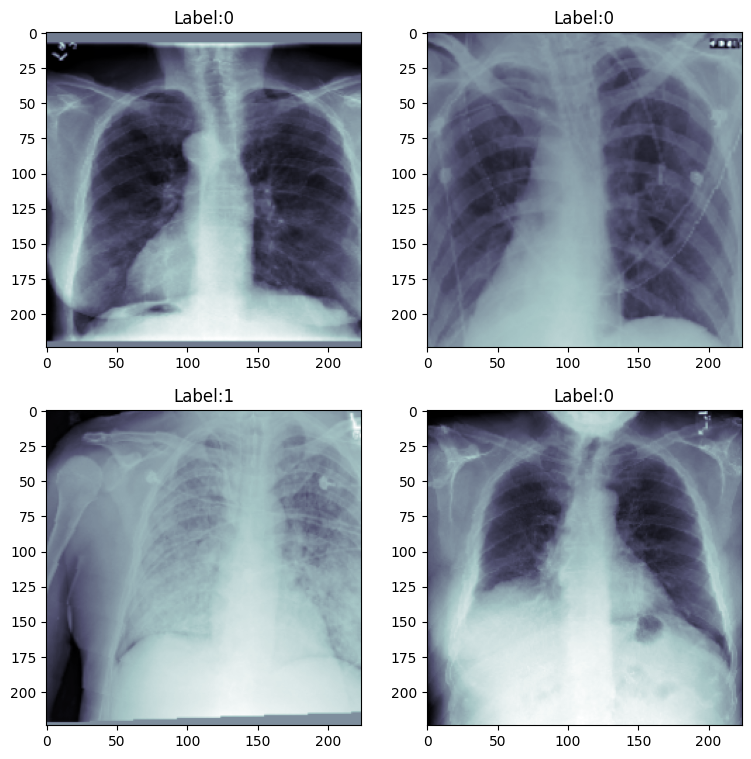

In [ ]:
fig, axis = plt.subplots(2, 2, figsize=(9, 9))
for i in range(2):
    for j in range(2):
        random_index = np.random.randint(0, 20000)
        x_ray, label = train_dataset[random_index]
        axis[i][j].imshow(x_ray[0], cmap="bone")
        axis[i][j].set_title(f"Label:{label}")

In [ ]:
batch_size = 64
num_procs = 4

train_loader = torch.utils.data.DataLoader(
    train_dataset, batch_size=batch_size, num_workers=num_procs, shuffle=True
)
val_loader = torch.utils.data.DataLoader(
    val_dataset, batch_size=batch_size, num_workers=num_procs, shuffle=True
)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [ ]:
np.unique(train_dataset.targets, return_counts=True), np.unique(val_dataset.targets, return_counts=True)

((array([0, 1]), array([16162,  5004])), (array([0, 1]), array([4510, 1008])))

**Create model in pytorch lightning**

Model: Resnet18

In [ ]:
class Resnet18PneumoniaModel(pl.LightningModule):
    def __init__(self, weight = 1):
        super().__init__()
        self.model = torchvision.models.resnet18()
        self.model.conv1 = torch.nn.Conv2d(
            1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
        )
        # Change out_features of Resnet18 last fully connected layer from 512 -> 1
        self.model.fc = torch.nn.Linear(in_features=512, out_features=1)
        self.optimizer = torch.optim.Adam(self.model.parameters(), lr=1e-4)
        self.loss_fn = torch.nn.BCEWithLogitsLoss(pos_weight=torch.tensor([weight]))

        # Accuracy computation
        self.train_acc = torchmetrics.Accuracy(task='binary')
        self.val_acc = torchmetrics.Accuracy(task='binary')

        # Initialize a list to store outputs for each training step
        self.training_outputs = []

    def forward(self, data):
        pred = self.model(data)
        return pred

    def training_step(self, batch, batch_index):
        x_ray, label = batch
        label = label.float()
        pred = self(x_ray)[:,0]
        loss = self.loss_fn(pred, label)

        self.log("Train Loss", loss)
        self.log("Train Acc", self.train_acc(torch.sigmoid(pred), label.int()))

        # Append outputs for this step to the list
        self.training_outputs.append(loss)

        return loss

    def on_train_epoch_end(self):
        # Do something with all training_step outputs
        # For example, you can calculate and log average loss
        avg_loss = torch.stack(self.training_outputs).mean()
        self.log('Train Acc', self.train_acc.compute())
        # Don't forget to clear the list for the next epoch
        self.training_outputs.clear()

    def validation_step(self, batch, batch_index):
        x_ray, label = batch
        label = label.float()
        pred = self(x_ray)[:,0]
        loss = self.loss_fn(pred, label)

        self.log("Val Loss", loss)
        self.log("Val Acc", self.val_acc(torch.sigmoid(pred), label.int()))

        return loss

    def on_validation_epoch_end(self):
        self.log("Val Acc", self.val_acc.compute())

    def configure_optimizers(self):
        return [self.optimizer]


In [ ]:
model = Resnet18PneumoniaModel()

In [ ]:
# Create the checkpoint callback
checkpoint_callback = ModelCheckpoint(
    monitor='Val Acc',
    save_top_k=10,
    mode='max')

In [ ]:
trainer = pl.Trainer(accelerator="auto", logger=TensorBoardLogger(save_dir="./logs"), log_every_n_steps=1,
                     callbacks=checkpoint_callback,
                     max_epochs=35)


INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


In [ ]:
trainer.fit(model, train_loader, val_loader)

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name      | Type              | Params
------------------------------------------------
0 | model     | ResNet            | 11.2 M
1 | loss_fn   | BCEWithLogitsLoss | 0     
2 | train_acc | BinaryAccuracy    | 0     
3 | val_acc   | BinaryAccuracy    | 0     
------------------------------------------------
11.2 M    Trainable params
0         Non-trainable params
11.2 M    Total params
44.683    Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:492: Your `val_dataloader`'s sampler has shuffling enabled, it is strongly recommended that you turn shuffling off for val/test dataloaders.
/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=35` reached.


Load checkpoint and send model to gpu then compute prediction



In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

model = Resnet18PneumoniaModel.load_from_checkpoint("/content/logs/lightning_logs/version_0/checkpoints/epoch=25-step=8606.ckpt")
model.eval()
model.to(device);

In [ ]:
preds = []
labels = []

with torch.no_grad():
    for data, label in tqdm(val_dataset):
        data = data.to(device).float().unsqueeze(0)
        pred = torch.sigmoid(model(data)[0].cpu())
        preds.append(pred)
        labels.append(label)
preds = torch.tensor(preds)
labels = torch.tensor(labels).int()

  0%|          | 0/5518 [00:00<?, ?it/s]

Print confusion matrix - accuracy - precision - recall

In [ ]:
acc = torchmetrics.Accuracy(task='binary')(preds, labels)
precision = torchmetrics.Precision(task='binary')(preds, labels)
recall = torchmetrics.Recall(task='binary')(preds, labels)
cm = torchmetrics.ConfusionMatrix(task='binary', num_classes=2)(preds, labels)
cm_threshed = torchmetrics.ConfusionMatrix(task='binary', num_classes=2, threshold=0.25)(preds, labels)

print(f"Val Accuracy: {acc}")
print(f"Val Precision: {precision}")
print(f"Val Recall: {recall}")
print(f"Confusion Matrix:\n {cm}")
print(f"Confusion Matrix 2:\n {cm_threshed}")

Val Accuracy: 0.8388909101486206
Val Precision: 0.5453160405158997
Val Recall: 0.7103174328804016
Confusion Matrix:
 tensor([[3913,  597],
        [ 292,  716]])
Confusion Matrix 2:
 tensor([[3266, 1244],
        [ 139,  869]])


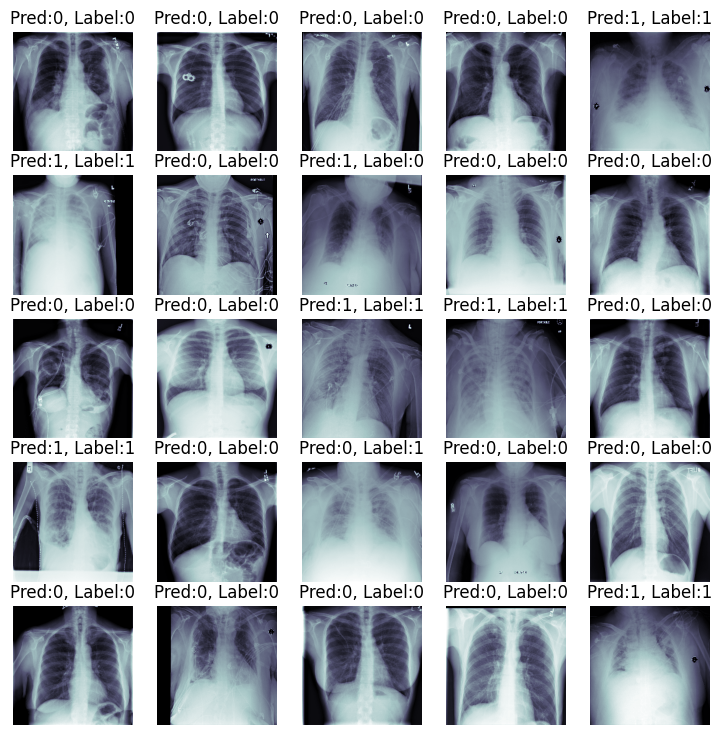

In [ ]:
fig, axis = plt.subplots(5, 5, figsize=(9, 9))

for i in range(5):
    for j in range(5):
        rnd_idx = np.random.randint(0, len(preds))
        axis[i][j].imshow(val_dataset[rnd_idx][0][0], cmap="bone")
        axis[i][j].set_title(f"Pred:{int(preds[rnd_idx] > 0.5)}, Label:{labels[rnd_idx]}")
        axis[i][j].axis("off")


**Define CAM function to visualize pneumonia**

In [ ]:
def cam(model, img):
  with torch.no_grad():
    pred, features = model(img.unsqueeze(0))
  b, c, h, w = features.shape

  # Reshape features tensor
  features = features.reshape((c, h*w))

  # Get only the weights, not the bias
  weight_params = list(model.model.fc.parameters())[0]

  # Remove gradient information to enable numpy conversation
  weight = weight_params[0].detach()

  cam = torch.matmul(weight, features)
  cam = torch.min(cam)
  cam_img = cam / torch.max(cam)
  # Reshape the class activation map
  cam_img = cam_img.reshape(h, w).cpu()

  return cam_img, torch.sigmoid(pred)

In [ ]:
def visualize(img, cam, pred):
    img = img[0]
    cam = transforms.functional.resize(cam.unsqueeze(0), (224, 224))[0]

    fig, axis = plt.subplots(1, 2)
    axis[0].imshow(img, cmap="bone")
    axis[1].imshow(img, cmap="bone")
    axis[1].imshow(cam, alpha=0.5, cmap="jet")
    plt.title(pred)

In [ ]:
img = val_dataset[-6][0].cuda()  # Select a subject
img.is_cuda
activation_map, pred = cam(model, img)

ValueError: ignored